# Inference for losers presentation animations

This notebook uses animations. To view these in your browser, go to this binder

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/dsbowen%2Fconditional-inference/HEAD?filepath=examples%2Flosers_presentation.ipynb)

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.stats import multivariate_normal, norm

from conditional_inference.bayes.classic import LinearClassicBayes
from conditional_inference.rqu import RQU
from conditional_inference.stats import quantile_unbiased, truncnorm

from utils import RankConditionAnimation, QuantileUnbiasedAnimation, confidence_ellipse

MOVERS_DATA_FILE = "../simulations/losers-empirical/movers.csv"
XLABEL = "Economic opportunity score"
TOP_N = 3
NEIGHBORHOOD = "Washington DC"

sns.set()
warnings.simplefilter("ignore")

rqu = RQU.from_csv(MOVERS_DATA_FILE)
index = rqu.exog_names.index(NEIGHBORHOOD)

## Conditional inference

In [2]:
%matplotlib notebook
y = np.array([0, 1, 2])
cov = np.array([
    [1, .5, 0],
    [.5, 1, -.2],
    [0, -.2, 1]
])
focal_index = 1
rank = [2]

ani = RankConditionAnimation(y, cov, focal_index, rank, xlim=(-2, 3)).make_animation(
    title="Conditioning on the policy being ranked 2nd",
    xlabel=r"Conventional estimates $Z_\theta$"
)
ani.save("truncation.gif")
plt.show()

In [3]:
%matplotlib notebook

sigma = np.sqrt(rqu.cov[index, index])
truncation_set = [(rqu.mean[np.argsort(-rqu.mean)][TOP_N], np.inf)]
x = rqu.mean[index]

ani = QuantileUnbiasedAnimation(
    x,
    sigma,
    truncation_set,
    xlim=(-.3, .5)
).make_animation(
    title="Conditional estimator",
    xlabel=f"Economic opportunity score for {NEIGHBORHOOD}"
)
ani.save("conditional.gif")
plt.show()

## Unconditional inference: projection CIs

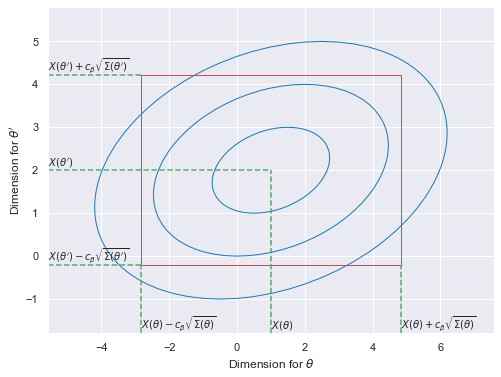

In [4]:
# conventional parameter estimates and covariance matrix
%matplotlib inline

x = [1, 2]
cov = np.array([
    [3, .5],
    [.5, 1]
])

palette = sns.color_palette()
scale = 3.8 * np.sqrt(np.diag(cov))
xlim = x[0] - scale[0], x[0] + scale[0]
ylim = x[1] - scale[1], x[1] + scale[1]

# draw confidence ellipse
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(xlim=xlim, ylim=ylim)
confidence_ellipse(x, cov, ax)

# draw K-dimensional rectangle containing 1 - \beta of the joint distribution
projection_length = RQU(x, cov).compute_projection_quantile(.05) * np.sqrt(np.diag(cov))
ax.add_patch(
    Rectangle(
        (x[0] - projection_length[0], x[1] - projection_length[1]),
        2 * projection_length[0],
        2 * projection_length[1],
        facecolor="none",
        edgecolor=palette[3]
    )
)

y_offset = .015 * (ylim[1] - ylim[0])

# projection onto the dimension for \theta
ax.set_xlabel(r"Dimension for $\theta$")
ax.axvline(x[0], ymax=.5, linestyle="--", color=palette[2])
ax.text(x[0], ylim[0] + y_offset, r"$X(\theta)$")
ymax = (ylim[1] - (x[1] + projection_length[1])) / (ylim[1] - ylim[0])
ax.axvline(x[0] - projection_length[0], ymax=ymax, linestyle="--", color=palette[2])
ax.text(x[0] - projection_length[0], ylim[0] + y_offset, r"$X(\theta) - c_\beta \sqrt{\Sigma(\theta)}$")
ax.axvline(x[0] + projection_length[0], ymax=ymax, linestyle="--", color=palette[2])
ax.text(x[0] + projection_length[0], ylim[0] + y_offset, r"$X(\theta) + c_\beta \sqrt{\Sigma(\theta)}$")

# project onto the dimension for \theta'
ax.set_ylabel(r"Dimension for $\theta'$")
ax.axhline(x[1], xmax=.5, linestyle="--", color=palette[2])
ax.text(xlim[0], x[1] + y_offset, r"$X(\theta')$")
xmax = (xlim[1] - (x[0] + projection_length[0])) / (xlim[1] - xlim[0])
ax.axhline(x[1] - projection_length[1], xmax=xmax, linestyle="--", color=palette[2])
ax.text(xlim[0], x[1] - projection_length[1] + y_offset, r"$X(\theta') - c_\beta \sqrt{\Sigma(\theta')}$")
ax.axhline(x[1] + projection_length[1], xmax=xmax, linestyle="--", color=palette[2])
ax.text(xlim[0], x[1] + projection_length[1] + y_offset, r"$X(\theta') + c_\beta \sqrt{\Sigma(\theta')}$")

fig.savefig("projection.png")
plt.show()

## Unconditional inference: hybrid estimator

In [5]:
%matplotlib notebook

ani = QuantileUnbiasedAnimation(
    rqu.mean[index],
    np.sqrt(rqu.cov[index, index]),
    truncation_set,
    projection_quantile=rqu.compute_projection_quantile(.005),
    xlim=(-.3, .5)
).make_animation(
    title="Hybrid estimator",
    xlabel=f"Economic opportunity score for {NEIGHBORHOOD}"
)
ani.save("hybrid.gif")
plt.show()